In [1]:
!pip install gymnasium
!pip install gymnasium[classic-control]

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F

import import_ipynb
from TrulyPlastic_allOpt import plastic_nn
from TrulyPlastic_allOpt import input_layer
from TrulyPlastic_allOpt import layer

importing Jupyter notebook from TrulyPlastic_allOpt.ipynb


In [3]:
# np.random.seed(4)

In [2]:

# Define memory for Experience Replay
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)




class MountainCarDQL():
    # Hyperparameters (adjustable)
    
    discount_factor_g = 0.9         # discount rate (gamma)
    network_sync_rate = 50000          # number of steps the agent takes before syncing the policy and target network
    replay_memory_size = 100000       # size of replay memory
    mini_batch_size = 64            # size of the training data set sampled from the replay memory

    num_divisions = 50

    
    def plot_progress(self, rewards_per_episode, epsilon_history):
        plt.figure(1)
        plt.subplot(121) 
        plt.plot(rewards_per_episode)
        plt.subplot(122) # plot on a 1 row x 2 col grid, at cell 2
        plt.plot(epsilon_history)
        plt.savefig('mountaincar_dql.png')

    

    def train(self, policy_dqn, target_dqn, episodes, render=False):
        # Create FrozenLake instance
        env = gym.make('MountainCar-v0', render_mode='human' if render else None)
        num_states = env.observation_space.shape[0] # expecting 2: position & velocity
        num_actions = env.action_space.n

        # Divide position and velocity into segments
        self.pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], self.num_divisions)    # Between -1.2 and 0.6
        self.vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], self.num_divisions)    # Between -0.07 and 0.07

        epsilon = 1 # 1 = 100% random actions
        memory = ReplayMemory(self.replay_memory_size)

        rewards_per_episode = []
        epsilon_history = []

        # Track number of steps taken. Used for syncing policy => target network.
        step_count = 0
        goal_reached = False
        best_rewards = -200

        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False
            rewards = 0

            # Agent navigates map until it falls into hole/reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and rewards > -1000):
                if random.random() < epsilon:
                    action = env.action_space.sample() # actions: 0=left,1=idle,2=right
                else:
                    res = policy_dqn.forward(self.state_to_dqn_input(state))
                    #print(res)
                    action = res.argmax().item()

                new_state,reward,terminated,truncated,_ = env.step(action)
                rewards += reward
                memory.append((state, action, new_state, reward, terminated))
                state = new_state
                step_count+=1


            rewards_per_episode.append(rewards)
            #epsilon_history.append(epsilon)
            
            if(terminated):
                goal_reached = True

            # Graph training progress
            if(i!=0 and i%1000==0):
                print(f'Episode {i} Epsilon {epsilon}')
                policy_dqn.save(f'mc_policy_{i}'.format(i))
                self.plot_progress(rewards_per_episode, epsilon_history)

            if rewards>best_rewards:
                best_rewards = rewards
                print(f'Best rewards so far: {best_rewards}')
                policy_dqn.save(f'mc_policy_{i}'.format(i))
                

            # Check if enough experience has been collected
            if len(memory)>self.mini_batch_size and goal_reached:
                
                #print(f'OPTIMIZE Episode {i} Epsilon {epsilon} rewards {rewards}') # print(rewards)
                
                mini_batch = memory.sample(self.mini_batch_size) #len(memory))#
                self.optimize(mini_batch, policy_dqn, target_dqn)

                # Decay epsilon
                epsilon = epsilon = max(epsilon - 1/episodes, 0.01) # max(epsilon*0.99996, 0.05)#
                epsilon_history.append(epsilon)

                # Copy policy network to target network after a certain number of steps
                if step_count > self.network_sync_rate:
                    target_dqn = policy_dqn.deep_copy()
                    step_count = 0
                    #print('UPDATE')
                   
                
                
        env.close()



    
    def optimize(self, mini_batch, policy_dqn, target_dqn):
        current_q_list = []
        target_q_list = []
        input_list = []

        
        for state, action, new_state, reward, terminated in mini_batch:

            if terminated:
                target = reward
            else:
                target = reward + self.discount_factor_g * target_dqn.forward(self.state_to_dqn_input(new_state)).max()
          
            # Get the current set of Q values
            # current_q = policy_dqn.forward(self.state_to_dqn_input(state))
            # current_q_list.append(current_q)
            in_state_dsc = np.asarray(self.state_to_dqn_input(state))
            
            input_list.append(in_state_dsc)

            
            # Get the target set of Q values
            target_q = target_dqn.forward(in_state_dsc)
            
            # Adjust the specific action to the target that was just calculated
            target_q[action] = target
            #print(in_state_dsc.shape)
            
            target_q_list.append(target_q)
            #target_q_list = np.asarray(target_q_list)
            #print(target_q_list.shape)
            

    
        #BACKPOP AND UPDATE on minibatch
        # print(input_list)
        # print(target_q)
        x = np.asarray(input_list)
        x = x[:, :, 0]
        x = x.T
        #print(x.shape)
        y = np.asarray(target_q_list)
        y = y[:, :, 0]
        y = y.T
        #print(x.shape)
        #print(target_q)
        #print('target_q_list ',target_q_list.shape)
        policy_dqn.learn_one(x, y)



    def state_to_dqn_input(self, state):
        state_p = np.digitize(state[0], self.pos_space)
        state_v = np.digitize(state[1], self.vel_space)

        return np.asarray([[state_p], [state_v]])

    # Run the environment with the learned policy
    def test(self, policy_dqn, episodes):
        # Create FrozenLake instance
        env = gym.make('MountainCar-v0', render_mode='human')
        num_states = env.observation_space.shape[0]
        num_actions = env.action_space.n

        self.pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], self.num_divisions)    # Between -1.2 and 0.6
        self.vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], self.num_divisions)    # Between -0.07 and 0.07

        for i in range(episodes):
            state, info = env.reset()  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False       # True when agent takes more than 200 actions

            # Agent navigates map until it falls into a hole (terminated), reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and not truncated):
                state = self.state_to_dqn_input(state)
                #print('state shape', state.shape)
               
                res = policy_dqn.forward(state)

                action = res.argmax().item()
                #print(res)
                state, reward, terminated, truncated, _ = env.step(action)
                
                #print('state shape', state.shape)
                
                # state = state[:, :, 0]
                # print('state shape', state.shape)
            
                # dscr = np.asarray(self.state_to_dqn_input(state))
                # print(dscr.shape)
                # #dscr = dscr.reshape(dscr[0], 1)
                # res = policy_dqn.forward(dscr)
                # #print(res)
                # action = res.argmax().item()

                # # Execute action
                # state,reward,terminated,truncated,_ = env.step(action)
                #terminated = True

        env.close()


In [3]:
learning_rate_a = 0.01
in_states = 2
h1_nodes = 20
h2_nodes = 20
out_actions = 3

layers_net = [input_layer(in_states), 
layer(lr = learning_rate_a, prev_size = in_states, my_size=h1_nodes, activation_type="ReLU"), 
#layer(lr = learning_rate_a, prev_size = h1_nodes, my_size=h2_nodes, activation_type="ReLU"), 
layer(lr = learning_rate_a, prev_size = h2_nodes, my_size=out_actions, activation_type='Linear')]

policy_dqn = plastic_nn(optimizer="Adam")
policy_dqn.append_layers(layers_net)

target_dqn = plastic_nn()
target_dqn = policy_dqn.deep_copy()
#a = np.asarray([[11], [12]])

added LAYERS succesfully


In [4]:
mountaincar = MountainCarDQL()

Episode 1000 Epsilon 0.9660500000000037
Episode 2000 Epsilon 0.9160500000000092
Episode 3000 Epsilon 0.8660500000000148
Episode 4000 Epsilon 0.8160500000000203
Episode 5000 Epsilon 0.7660500000000258
Episode 6000 Epsilon 0.7160500000000313
Episode 7000 Epsilon 0.6660500000000368
Episode 8000 Epsilon 0.6160500000000423
Episode 9000 Epsilon 0.5660500000000478
Episode 10000 Epsilon 0.5160500000000533
Episode 11000 Epsilon 0.4660500000000588
Episode 12000 Epsilon 0.4160500000000643
Episode 13000 Epsilon 0.3660500000000698
Episode 14000 Epsilon 0.3160500000000753
Best rewards so far: -196.0
Episode 15000 Epsilon 0.26605000000008083
Episode 16000 Epsilon 0.21605000000008634
Episode 17000 Epsilon 0.16605000000009185
Episode 18000 Epsilon 0.11605000000009735
Episode 19000 Epsilon 0.06605000000010286


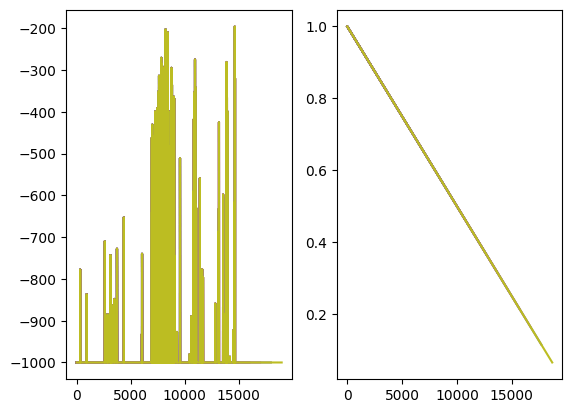

In [7]:
mountaincar.train(policy_dqn, target_dqn, 20000, False)

In [5]:
policy_dqn.load('mc_policy_14649')

added LAYERS succesfully


In [6]:
mountaincar.test(policy_dqn, 4)

In [10]:
policy_dqn.print_info()

NAME:  noname  ( 3 )
# 0
IN LAYER
size:  2

# 1
my size:  20
prev size:  2
w:  [[-1.42604271e-01  4.91774026e-02]
 [-1.61737089e-01  8.13014781e-02]
 [ 5.51689625e-02 -1.27806614e-01]
 [-2.43820291e-01 -7.67588049e-03]
 [-1.80868559e-01 -1.68990953e-02]
 [-4.79651602e-01  2.73962033e-03]
 [-2.73314739e-01  4.87380746e-03]
 [-7.20152137e-02 -1.01200538e-03]
 [-5.08010389e-02  2.71859557e-01]
 [-3.27941014e-01  1.40511318e-01]
 [-1.68927808e-01 -2.77216663e-04]
 [-2.24713575e-02 -4.16400257e-02]
 [-4.87328315e-01  1.33803602e-03]
 [ 3.47378858e-01 -1.97111084e-01]
 [-4.44474307e-01  2.92638880e-01]
 [-1.66589482e-01  4.61197450e-03]
 [ 9.44240458e-02  2.22236472e-01]
 [ 8.85187056e-02 -5.45793759e-02]
 [-3.81550545e-02  7.02427093e-02]
 [-3.17373484e-03  6.50914932e-04]] 

b:  [[-1.42604271e-01  4.91774026e-02]
 [-1.61737089e-01  8.13014781e-02]
 [ 5.51689625e-02 -1.27806614e-01]
 [-2.43820291e-01 -7.67588049e-03]
 [-1.80868559e-01 -1.68990953e-02]
 [-4.79651602e-01  2.73962033e-03]
 [-2

In [11]:
policy_dqn.print_info()

NAME:  noname  ( 3 )
# 0
IN LAYER
size:  2

# 1
my size:  20
prev size:  2
w:  [[-1.42604271e-01  4.91774026e-02]
 [-1.61737089e-01  8.13014781e-02]
 [ 5.51689625e-02 -1.27806614e-01]
 [-2.43820291e-01 -7.67588049e-03]
 [-1.80868559e-01 -1.68990953e-02]
 [-4.79651602e-01  2.73962033e-03]
 [-2.73314739e-01  4.87380746e-03]
 [-7.20152137e-02 -1.01200538e-03]
 [-5.08010389e-02  2.71859557e-01]
 [-3.27941014e-01  1.40511318e-01]
 [-1.68927808e-01 -2.77216663e-04]
 [-2.24713575e-02 -4.16400257e-02]
 [-4.87328315e-01  1.33803602e-03]
 [ 3.47378858e-01 -1.97111084e-01]
 [-4.44474307e-01  2.92638880e-01]
 [-1.66589482e-01  4.61197450e-03]
 [ 9.44240458e-02  2.22236472e-01]
 [ 8.85187056e-02 -5.45793759e-02]
 [-3.81550545e-02  7.02427093e-02]
 [-3.17373484e-03  6.50914932e-04]] 

b:  [[-1.42604271e-01  4.91774026e-02]
 [-1.61737089e-01  8.13014781e-02]
 [ 5.51689625e-02 -1.27806614e-01]
 [-2.43820291e-01 -7.67588049e-03]
 [-1.80868559e-01 -1.68990953e-02]
 [-4.79651602e-01  2.73962033e-03]
 [-2

In [12]:
a = [[10, 11], [6, 6], [9, 14], [7, 10], [8, 12], [7, 10], [7, 9], [9, 10], [8, 9], [8, 9], [9, 12], [7, 8], [5, 10], [7, 10], [10, 12], [9, 12], [7, 9], [8, 11], [7, 9], [11, 9], [7, 7], [10, 9], [8, 11], [10, 11], [7, 13], [9, 10], [8, 9], [8, 9], [8, 10], [8, 10], [9, 11], [6, 16]]